# Nonlinear Registration

## Introduction

In this exercise, you will implement sum-of-squared differences-based nonlinear registration using the Gauss-Newton algorithm. To simplify the exercise, you will register a 2D (sagittal) slice of a brain MRI scan of two different subjects; the images have been preprocessed (affinely aligned in 3D and resampled) so that you can (*exceptionally, for this exercise!*) assume that world coordinates and voxel coordinates are the same.

### Instructions for your report
Your report should be structured as follows:
* **Introduction**: a short summary of what your report is about, perhaps with a recap of some of the equations you'll be using in your solution.
* **Task 1, ..., 5**: for each specific task listed below, your code (in code cells), your results (as figures) as well as explanations of what is computed and what is shown in the figures (in Markdown cells).
* **Conclusion**: a short summary of your findings.

This introduction should **not** be part of your report.

### Input data and code hints
Import Python libraries:

In [1]:
import numpy as np
np.set_printoptions( suppress=True )
from matplotlib import pyplot as plt
plt.ion()
from scipy.ndimage import map_coordinates
import nibabel as nib

Read the two 3D scans you'll be working with in this exercise and select 2D slices:

In [5]:
fixed = nib.load( '/content/IXI092-HH-1436-IXIMADisoTFE12_-s3T134_-0301-00003-000001-01.nii' ).get_fdata()
moving = nib.load( '/content/IXI097-HH-1619-T1_resampled.nii' ).get_fdata()

fixed, moving = fixed[ ..., 73 ], moving[ ..., 73 ] # get slices

Below are three functions which let you visualize the images and corresponding grids in the same way. You can use these functions through all tasks where needed.

Text(0.5, 0.98, 'Image Grid')

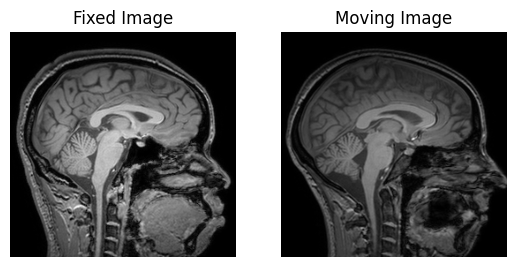

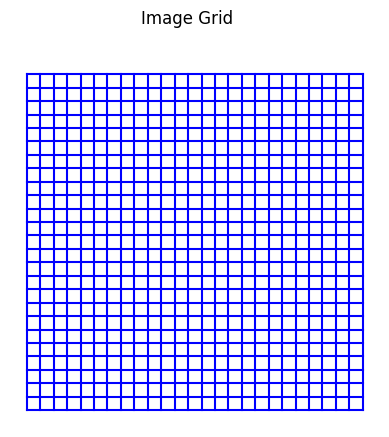

In [6]:
def visualize_image( ax, im, **kwargs ):
    # Visualize an image the same way the grid and vector fields are drawn: to the right means
    # x1 (row number in image matrix) goes up, and to the top means x2 (column number in image
    # matrix) goes up.
    ax.imshow( np.flipud( im.T ), **kwargs )
    ax.set_aspect( 'equal' )
    ax.axis( False )

def plot_grid( ax, X1, X2, **kwargs ):
    for i in range(X1.shape[0]):
        ax.plot(X1[i,:], X2[i,:], **kwargs)
    for i in range(X1.shape[1]):
        ax.plot(X1[:,i], X2[:,i], **kwargs)

def visualize_grid( ax, X1, X2 ):
    N1, N2 = X1.shape
    plot_grid( ax, X1[ ::10, ::10 ], X2[ ::10, ::10 ], color='b' )
    ax.set_aspect( 'equal' )
    ax.axis( False )

fixed = np.flipud( fixed )
moving = np.flipud( moving )

fig, ax = plt.subplots( 1, 2 )
visualize_image( ax[0], fixed, cmap='gray' )
visualize_image( ax[1], moving, cmap='gray' )
ax[0].set_title("Fixed Image")
ax[1].set_title("Moving Image")

X1, X2 = np.meshgrid( np.arange(fixed.shape[0]), np.arange(fixed.shape[1]), indexing='ij' )
fig, ax = plt.subplots()
visualize_grid( ax, X1, X2 )
fig.suptitle("Image Grid")

In this exercise, you'll be asked to compute and display image histograms, and to indicate the location of a specific intensity value in the histogram plot. The code snippet below shows how this can be done:

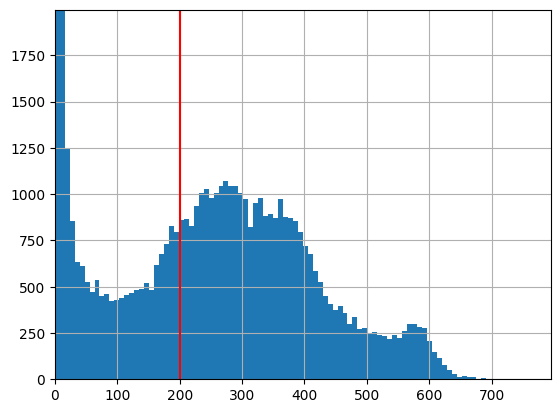

In [7]:
data = fixed
value = np.median( data )

histogram, edges = np.histogram( data.ravel(), bins=100 )
binCenters = ( edges[ 1: ] + edges[ :-1 ] ) / 2
binWidth = edges[ 1 ] - edges[ 0 ]
fig, ax = plt.subplots()
ax.bar( binCenters, histogram, width=binWidth )
ax.set_ylim( 0, histogram[1:].max() )  # clip the entry for background
ax.set_xlim( 0, data.max() )
ax.plot( [ value ]*2, ax.get_ylim(), 'r' )
ax.grid()


## Task 1: Normalize the intensity values of both images

Since MRI images are not calibrated, the pixel intensities in the fixed and the moving image are not necessarily comparable. As a first attempt to normalize the intensity values, divide each image by its maximum intensity value (to bring both images in the range $[0,1]$) and display both images, as well as their histograms, side by side. Are the intensity values now comparable between the two images?
> ***Hints:***
> - To avoid automatic rescaling of the visualization color map, you should perform the visualization as follows:
>        visualize_image( ax, fixed, cmap='gray', vmin=0, vmax=1 )

Compute a *robust* version of the maximum intensity in each image by locating the intensity value in the histogram so that 99% of the image pixels have a lower intensity. For each image, indicate the location of the value you find in the histogram using a verticle line (see code snippet given in the introduction).

Now rescale the image intensities again, this time using the robust maximum value instead. (Intensities higher than the robust maximum should be clipped so that all intensities fall within the range $[0,1]$ after intensity normalization.) Display both normalized images, as well as their histograms, side by side again. Decide which normalization method makes the image intensities more comparable, explain why, and perform the remainder of the exercise using the normalized images of your choice.

Max value in fixed image: 795.0 	 Max value in the moving image: 1243.55224609375


Text(0.5, 1.0, 'M_Norm Histogram')

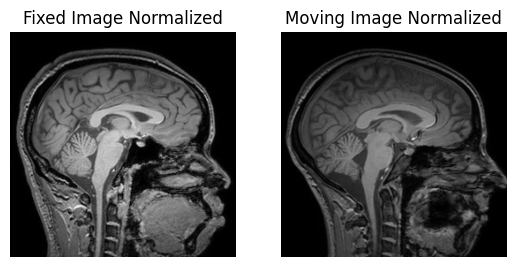

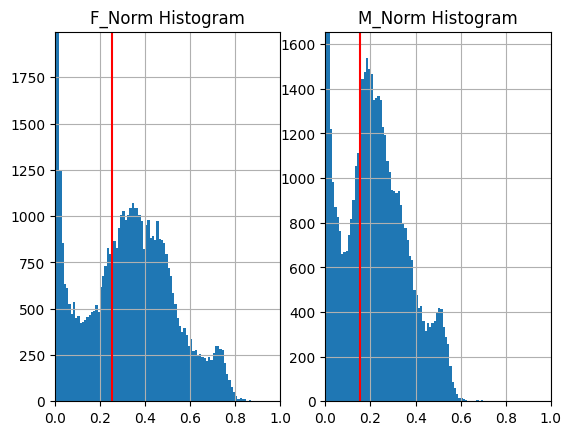

In [22]:
max_fixed, max_moving = fixed.max(), moving.max()
print(f"Max value in fixed image: {max_fixed} \t Max value in the moving image: {max_moving}")

fixed_normalized = fixed/max_fixed
moving_normalized = moving/max_moving

fig, ax = plt.subplots( 1, 2 )

visualize_image( ax[0], fixed_normalized, cmap='gray', vmin=0, vmax=1 )
visualize_image( ax[1], moving_normalized, cmap='gray', vmin=0, vmax=1 )
#visualize_image( ax[0], fixed_normalized, cmap='gray' )
#visualize_image( ax[1], moving_normalized, cmap='gray' )
ax[0].set_title("Fixed Image Normalized")
ax[1].set_title("Moving Image Normalized")

data_f_norm = fixed_normalized
value_f_norm = np.median(data_f_norm)

data_m_norm = moving_normalized
value_m_norm = np.median(data_m_norm)

fig, (ax1, ax2) = plt.subplots( 1, 2 )
#fixed image normalized histogram
histogram_f_norm, edges_f_norm = np.histogram( data_f_norm.ravel(), bins=100 )
binCenters_f_norm = ( edges_f_norm[ 1: ] + edges_f_norm[ :-1 ] ) / 2
binWidth_f_norm = edges_f_norm[ 1 ] - edges_f_norm[ 0 ]
ax1.bar(binCenters_f_norm, histogram_f_norm, width=binWidth_f_norm)
ax1.set_ylim(0, histogram_f_norm[1:].max())
ax1.set_xlim(0, fixed_normalized.max())
ax1.plot([value_f_norm]*2, ax1.get_ylim(), 'r')
ax1.grid()
ax1.set_title("F_Norm Histogram")
#moving image normalized histogram
histogram_m_norm, edges_m_norm = np.histogram( data_m_norm.ravel(), bins=100 )
binCenters_m_norm = ( edges_m_norm[ 1: ] + edges_m_norm[ :-1 ] ) / 2
binWidth_m_norm = edges_m_norm[ 1 ] - edges_m_norm[ 0 ]
ax2.bar(binCenters_m_norm, histogram_m_norm, width=binWidth_m_norm)
ax2.set_ylim(0, histogram_m_norm[1:].max())
ax2.set_xlim(0, moving_normalized.max())
ax2.plot([value_m_norm]*2, ax1.get_ylim(), 'r')
ax2.grid()
ax2.set_title("M_Norm Histogram")


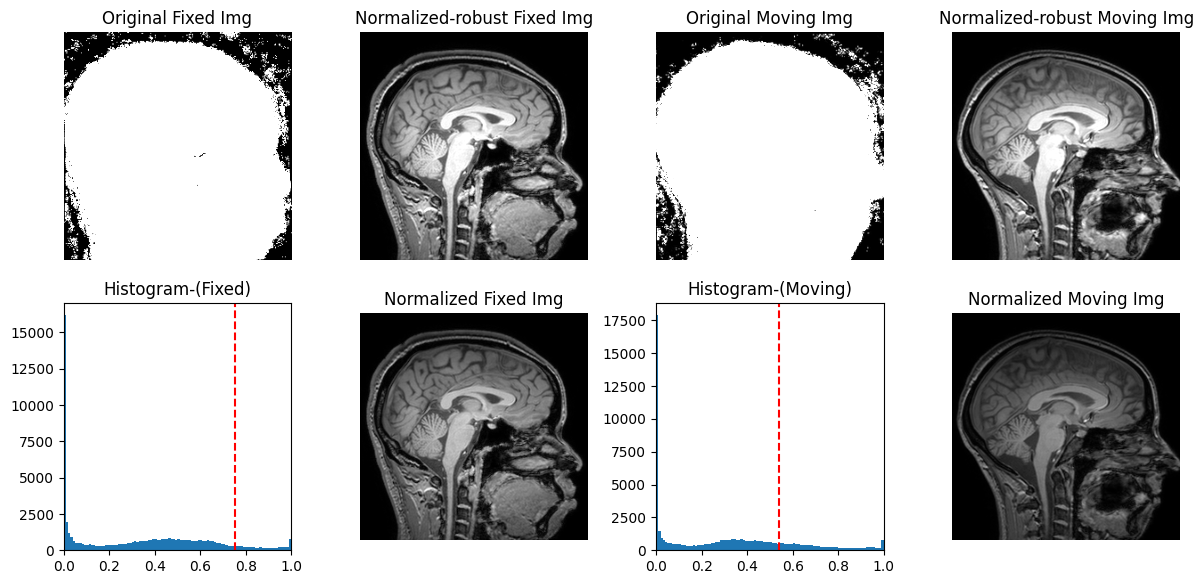

In [15]:
# Normalize to [0,1]
norm_fixed = fixed/fixed.max()
norm_moving = moving/moving.max()

justnorm_fixed = fixed/fixed.max()
justnorm_moving = moving/moving.max()

# Compute robust maximum intensity values
def compute_robust_max_intensity(image, percentile):
    # Compute histogram
    histogram, edges =np.histogram(image.ravel(), bins=100)

    percentile_value =np.percentile(image, percentile)
    return percentile_value

# again robust_normalized images
robust_max_fixed =compute_robust_max_intensity(norm_fixed, 99)
robust_max_moving =compute_robust_max_intensity(norm_moving, 99)

# rescaling
norm_fixed = np.clip(norm_fixed,0, robust_max_fixed)/robust_max_fixed
norm_moving = np.clip(norm_moving, 0,robust_max_moving)/robust_max_moving

# plotting
fig, axes = plt.subplots(2, 4,figsize=(12,6))

visualize_image(axes[0,0], fixed, cmap='gray', vmin=0, vmax=1)
visualize_image(axes[0,1], norm_fixed, cmap='gray', vmin=0, vmax=1)
visualize_image(axes[0,2], moving, cmap='gray', vmin=0, vmax=1)
visualize_image(axes[0,3], norm_moving, cmap='gray', vmin=0, vmax=1)

visualize_image(axes[1,1], justnorm_fixed, cmap='gray', vmin=0, vmax=1)
visualize_image(axes[1,3], justnorm_moving, cmap='gray', vmin=0, vmax=1)



# Compute and visualize the histograms
hist_fixed, edges_fixed = np.histogram(norm_fixed.ravel(), bins=100)
hist_moving, edges_moving = np.histogram(norm_moving.ravel(), bins=100)

# histograms
axes[1,0].bar((edges_fixed[1:] +edges_fixed[:-1])/2, hist_fixed, width=edges_fixed[1]- edges_fixed[0])
axes[1,2].bar((edges_moving[1:]+ edges_moving[:-1])/2, hist_moving, width=edges_moving[1]- edges_moving[0])

# robust maximum values on the histograms with red dashed lines
axes[1,0].axvline(robust_max_fixed, color='r', linestyle='--')
axes[1,2].axvline(robust_max_moving, color='r', linestyle='--')

axes[1,0].set_xlim(0,1)
axes[1,2].set_xlim(0,1)

# titles & labels
axes[0,0].set_title("Original Fixed Img")
axes[0,1].set_title("Normalized-robust Fixed Img")
axes[0,2].set_title("Original Moving Img")
axes[0,3].set_title("Normalized-robust Moving Img")
axes[1,1].set_title("Normalized Fixed Img")
axes[1,3].set_title("Normalized Moving Img")


axes[1,0].set_title("Histogram-(Fixed)")
axes[1,2].set_title("Histogram-(Moving)")


plt.tight_layout()
plt.show()


## Task 2: Create basis functions for nonlinear deformation
In order to model the residual deformation in each direction $d=1,\ldots,D$, you are going to use a weighted set of basis functions:
$$
\delta_d(\mathbf{x}, \mathbf{w}_d) = \sum_{m=0}^{M-1} w_{d,m}\phi_m (\mathbf{x})
.
$$
Here $\phi_m (\mathbf{x})$ are $M$ basis functions, and $\mathbf{w}_d$ are the weights for direction $d$.
For the purpose of this exercise, construct a set of $M=7 \times 7=49$ separable, 2D cubic B-spline basis functions that cover the image area of the fixed image. Include a visualization of the basis functions, plotted in a $7 \times 7$ grid, in your report.

> ***Hint:***
> - You should reuse the code for the 2D B-Spline basis functions that you implemented for the exercise about image smoothing.

For the purpose of the exercise, retain only the central part of $5 \times 5$ basis functions, removing all the B-splines that are centered on one of the image edges. This will avoid strangle-looking, large deformations of the image edges later on.

> ***Hint:***
> - There are several ways of doing this. One option is to construct the 25 2D basis functions from only the 5 central 1D basis functions in each direction to start with:  
>        np.kron( Phi2[:,1:-1], Phi1[:,1:-1] )
> instead of
>        np.kron( Phi2, Phi1 )


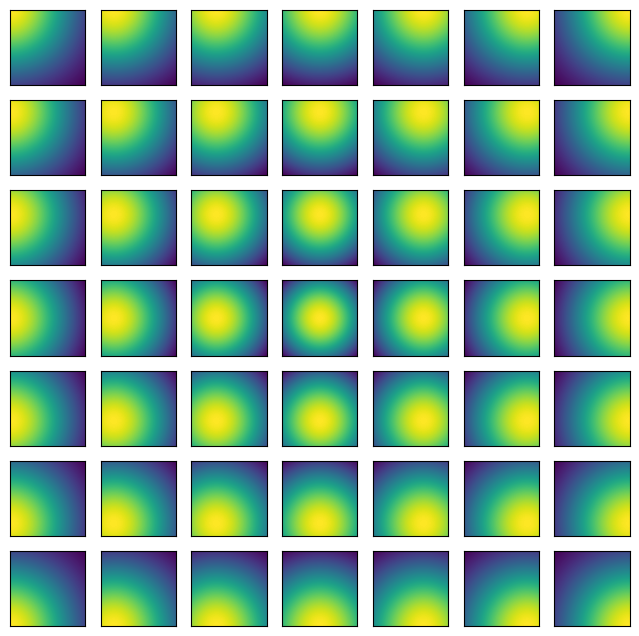

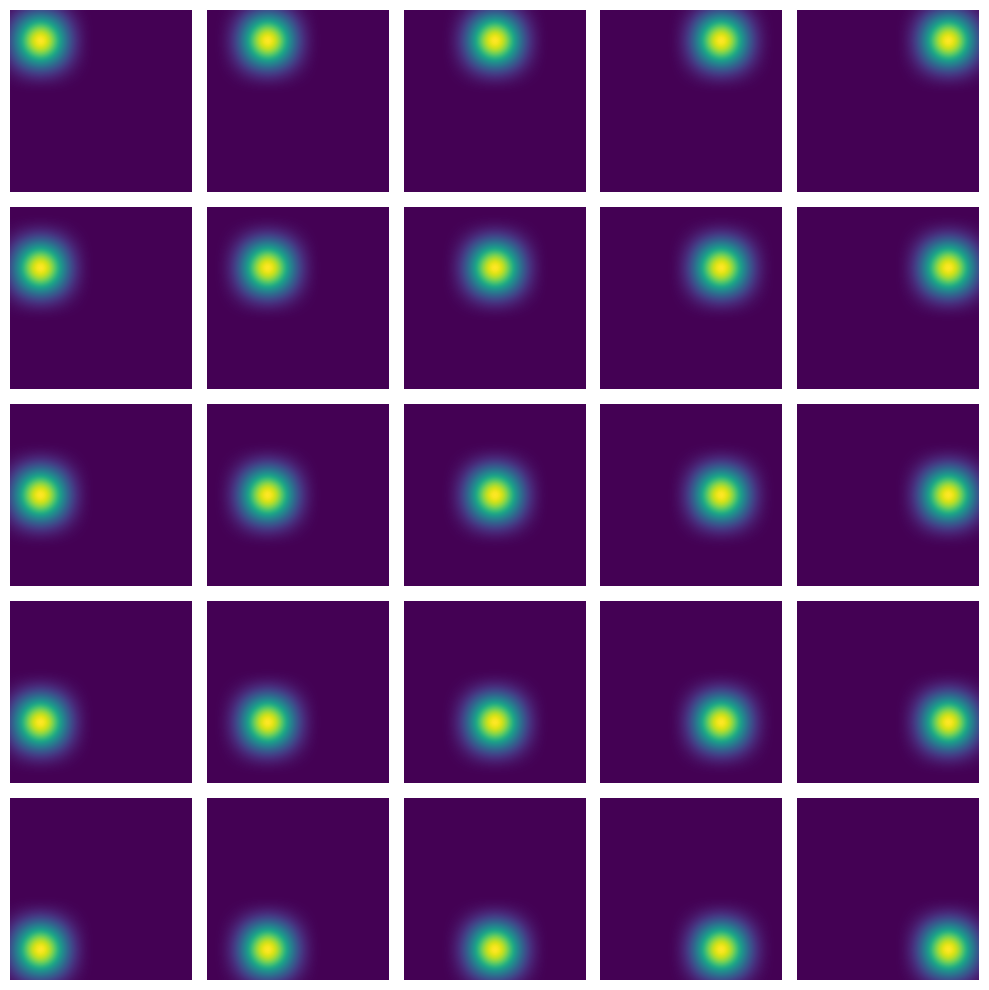

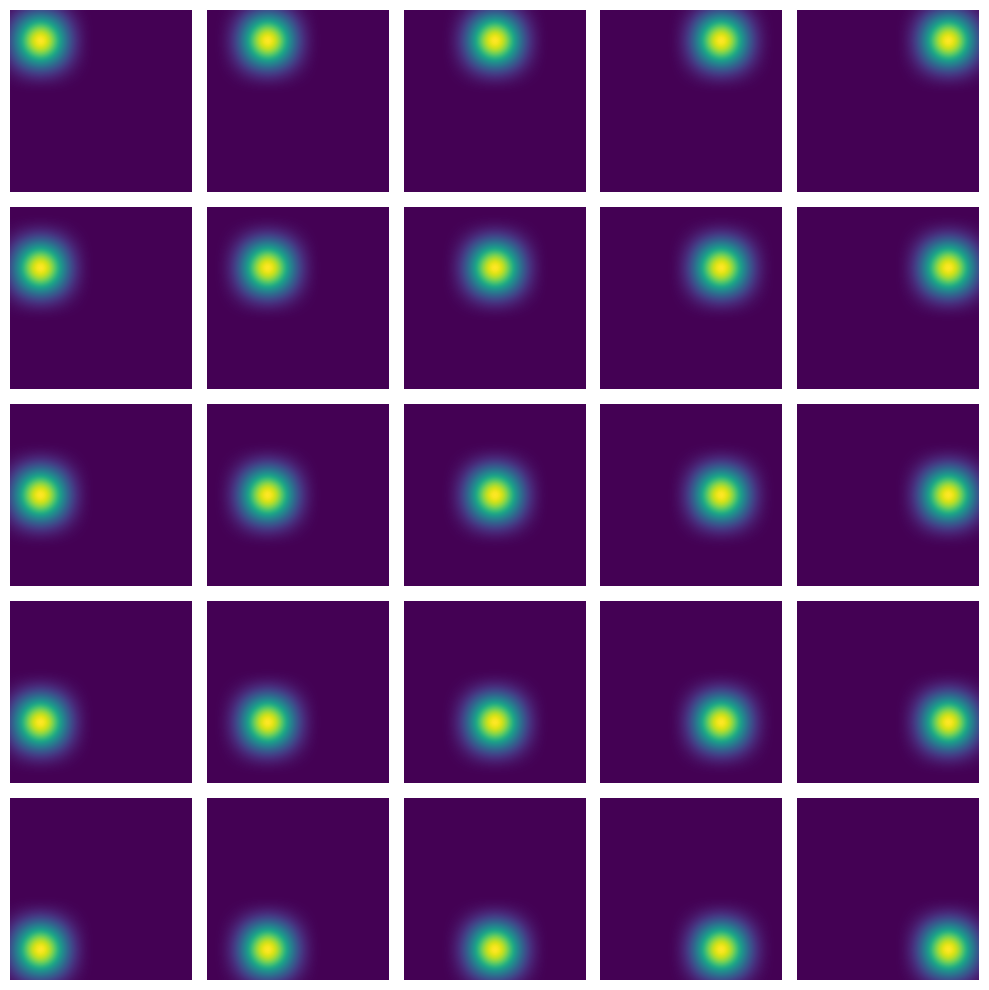

In [24]:
def evaluateUniformBSpline(x, shift, order):
    def bspline_order0(x,shift):
        return np.where((x >= -0.5+shift) & (x < 0.5+shift), 1, 0)

    def bspline_order1(x,shift):
        return np.piecewise(x, [x < -1+shift, (x >= -1+shift) & (x < 1+shift), x >= 1+shift],
                            [0,
                             lambda x: 1 - np.abs(x-shift),
                             0])

    def bspline_order3(x,shift):
        return np.piecewise(x,
                            [x < -2+shift, (x >= -2+shift) & (x < -1+shift), (x >= -1+shift) & (x < 1+shift), (x >= 1+shift) & (x < 2+shift), x >= 2+shift],
                            [0,
                             lambda x: (1/6) * (2 - np.abs(x-shift))**3,
                             lambda x: (2/3) - (np.abs(x-shift))**2 + (1/2)*( np.abs(x-shift))**3,
                             lambda x: (1/6) * (2- np.abs(x-shift))**3,
                             0])

    if order == 0:
        return bspline_order0(x,shift)
    elif order == 1:
        return bspline_order1(x,shift)
    elif order == 3:
        return bspline_order3(x,shift)
    else:
        raise ValueError("Order should be 0, 1, or 3")


import numpy as np
import matplotlib.pyplot as plt

# Define the dimensions and number of basis functions
M = 7  # Number of basis functions in each dimension
width, height = fixed.shape  # Dimensions of the fixed image

# Create a uniform grid of control points in both dimensions
control_points_x = np.linspace(0, 1, M)
control_points_y = np.linspace(0, 1, M)

# Initialize a figure with a grid of subplots
fig, axes = plt.subplots(M, M, figsize=(8, 8))

# Evaluate and plot the B-spline basis functions in a grid
for i in range(M):
    for j in range(M):
        basis_x = evaluateUniformBSpline(np.linspace(0, 1, width),
                                         control_points_x[i], order=3)
        basis_y = evaluateUniformBSpline(np.linspace(0, 1, height),
                                         control_points_y[j], order=3)

        basis = np.outer(basis_x, basis_y)

        # Plot the basis function
        axes[i, j].imshow(basis, cmap='viridis')
        axes[i, j].set_xticks([])
        axes[i, j].set_yticks([])

plt.show()


#########################################################################


#B-spline basis functions evaluated along the rows
M_rows = 7

N=256
x_basis_rows = np.arange(0, N)
Phi1 = np.zeros((N, M_rows))
h_rows = (N-1) / (M_rows-1)

for m in range(M_rows):
    shift_basis_rows = m * h_rows
    basis_function_rows = evaluateUniformBSpline((x_basis_rows - shift_basis_rows) / h_rows, 0, order=3)
    Phi1[:, m] = basis_function_rows



#B-spline basis functions evaluated along the columns
M_cols = 7
x_basis_cols = np.arange(0, N)
Phi2 = np.zeros((N, M_cols))
h_cols = (N-1) / (M_cols-1)

for m in range(M_cols):
    shift_basis_cols = m * h_cols
    basis_function_cols = evaluateUniformBSpline((x_basis_cols - shift_basis_cols) / h_cols, 0, order=3)
    Phi2[:, m] = basis_function_cols


Phi2D = np.kron(Phi2[:, 1:-1], Phi1[:, 1:-1])  # Retain central part only

# Visualize the Basis Functions in a 7x7 grid
plt.figure(figsize=(10, 10))
for i in range(M_rows-2):
    for j in range(M_cols-2):
        plt.subplot(M_rows-2, M_cols-2, i*(M_cols-2)+j+1)
        basis_function_2D = Phi2D[:,i*(M_cols-2)+j].reshape(N, N)
        plt.imshow(basis_function_2D, cmap='viridis')
        plt.axis('off')

plt.tight_layout()
plt.show()



###################################################################################

# B-spline basis functions evaluated along the rows
M_rows = 7
N = 256
x_basis_rows = np.arange(0, N)
Phi1 = np.zeros((N, M_rows))
h_rows = (N - 1) / (M_rows - 1)

for m in range(M_rows):
    shift_basis_rows = m * h_rows
    basis_function_rows = evaluateUniformBSpline((x_basis_rows - shift_basis_rows) / h_rows, 0, order=3)
    Phi1[:, m] = basis_function_rows

# B-spline basis functions evaluated along the columns
M_cols = 7
x_basis_cols = np.arange(0, N)
Phi2 = np.zeros((N, M_cols))
h_cols = (N - 1) / (M_cols - 1)

for m in range(M_cols):
    shift_basis_cols = m * h_cols
    basis_function_cols = evaluateUniformBSpline((x_basis_cols - shift_basis_cols) / h_cols, 0, order=3)
    Phi2[:, m] = basis_function_cols

# Create Phi2D by computing the outer product of Phi1 and Phi2
Phi2D = np.kron(Phi2[:, 1:-1], Phi1[:, 1:-1])  # Retain central part only

# Visualize the Basis Functions in a 7x7 grid
plt.figure(figsize=(10, 10))
for i in range(M_rows - 2):
    for j in range(M_cols - 2):
        plt.subplot(M_rows - 2, M_cols - 2, i * (M_cols - 2) + j + 1)
        basis_function_2D = Phi2D[:, i * (M_cols - 2) + j].reshape(256, 256)
        plt.imshow(basis_function_2D, cmap='viridis')
        plt.axis('off')

plt.tight_layout()
plt.show()

## Task 3: Manipulate the image locally with basis function

In this task, you will use two weight vectors $\mathbf{w}_1$ and $\mathbf{w}_2$ to control the transformation model
$$
y_d(\mathbf{x}, \mathbf{w}_d) = x_d + \delta_d(\mathbf{x}, \mathbf{w}_d), \quad d=1,2
,
$$
and visualize the effect of changing these weights on the resulting image deformation.
For each choice of weights, you should show (1) how a regular image grid defined in the space of the fixed image looks after deformation, and (2) the corresponding interpolated moving image, resampled to the image grid of the fixed image.

In a first experiment, set all elements of $\mathbf{w}_2$ to zero, and set all elements *except one* in $\mathbf{w}_1$ to zero. Try a few different values for the one non-zero entry, show each time the resulting deformated image grid and the interpolated moving image, and comment on what you see.

In a second experiment, apply a non-zero value to the corresponding (i.e., controlling the same 2D basis function) element in $\mathbf{w}_2$ as well. Again visualize the result and comment.

> ***Hints:***
> - Plot the deformed grid with the function visualize_grid() provided in the introduction, following the example of the non-deformed grid that was given.
> - View your deformed moving image with the function visualize_image() that was provided.

## Task 4: Implement Gauss-Newton optimization
Search for the weight vector $\mathbf{w} = (\mathbf{w}_1, \mathbf{w}_2)^T$ that minimizes the sum-of-squared-differences energy
$$
E(\mathbf{w}) = \sum_{n=1}^N \left[ \mathcal{F}(\mathbf{x}_n) - \mathcal{M}(\mathbf{y}(\mathbf{x}_n, \mathbf{w})) \right]^2
,
$$
using the Gauss-Newton algorithm described on page 24-25 in the book.
Start from a zero weight vector $\mathbf{w}$ (corresponding to no deformation), and update $\mathbf{w}$ for 100 iterations. For the first and every 20-th subsequent iteration, show both the deformed image grid and the resampled moving image. Also plot how the energy changes across all the 100 iterations.

> ***Hints:***
> - Use a $\mathbf{\delta}$ step value of e.g. $0.001$
> - The diagonal elements of the matrix $\mathbf{G}_1$ contain partial spatial derivatives of the moving image in the first dimension (row direction). If y1 and y2 are vectors containing the mapped coordinates (first and second dimension, respectively) of all $N$ pixels of the fixed image, these diagonal elements can be approximated using
>        
>   ( map_coordinates( moving, [ y1 + delta, y2 ] ) - map_coordinates( moving, [ y1, y2 ] ) ) / delta
>
>     for a small value of delta. The same applies to $\mathbf{G}_2$ (where delta is added to y2 instead of y1).
> - For an efficient implementation, it is worth considering what the effect is of $\mathbf{G}_d \boldsymbol{\Phi}$ on $\boldsymbol{\Phi}$ *without* implementing it literally as a matrix product.
> - If you find that the energy does not consistently go down across the iterations (by visual inspection of the energy curve), you can try to implement the Levenberg-Marquardt variant described in the book.


## Task 5: Experiment with different numbers of Basis Functions

Re-run the registration when the number of basis functions is altered (e.g., $3x3$ or $7x7$ instead of $5x5$) and inspect the outcomes. In your report, comment on differences in the results.